# Chapter 1.2 — Embeddings: Giving Tokens Meaning

*Establishing relationships between words through meaning*

Companion article: https://medium.com/@vadidsadikshaikh/chapter-1-2-embeddings-giving-tokens-meaning
Reference: Sebastian Raschka, *Build a Large Language Model (From Scratch)*

Purpose: implement a simple embedding lookup using PyTorch and visualize how token IDs map to vectors.

## Why embeddings?

Tokenization turns text into integers. Embeddings turn those integers into **dense vectors** that encode semantic relationships. In this notebook we:

1. Encode a short sentence with the same `tiktoken` tokenizer used in Chapter 1.1.
2. Create a PyTorch `nn.Embedding` layer and map token IDs to vectors.
3. Inspect shapes and a truncated vector sample.
4. (Optional) Visualize a small set of token vectors in 2D using PCA.

In [1]:
# Imports
import tiktoken
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# PCA for visualization (optional). If sklearn is not available, the cell will try a simple SVD fallback.
try:
    from sklearn.decomposition import PCA
    _HAS_SKLEARN = True
except Exception:
    _HAS_SKLEARN = False
    from math import sqrt


In [2]:
# Initialize tokenizer (GPT-2 BPE encoding) — same as Chapter 1.1
tokenizer = tiktoken.get_encoding("gpt2")
print("Loaded tokenizer:", "gpt2")
print("Vocab size:", getattr(tokenizer, 'n_vocab', None))


Loaded tokenizer: gpt2
Vocab size: 50257


In [3]:
# Sample text and tokenization
text = "Large language models read the world as numbers."
token_ids = tokenizer.encode(text)
print("Text:\n", text)
print("\nToken IDs:\n", token_ids)
print("Number of tokens:", len(token_ids))


Text:
 Large language models read the world as numbers.

Token IDs:
 [21968, 3303, 4981, 1100, 262, 995, 355, 3146, 13]
Number of tokens: 9


In [4]:
# Create an embedding layer
vocab_size = getattr(tokenizer, 'n_vocab', 50257)
embedding_dim = 128   # smaller dim for demo; later you can set 768 or 1024

embedding_layer = nn.Embedding(vocab_size, embedding_dim)

# Convert token ids to a tensor (batch size 1)
ids_tensor = torch.tensor([token_ids], dtype=torch.long)

# Forward pass through embedding
embeddings = embedding_layer(ids_tensor)  # shape: (1, seq_len, embedding_dim)
print("Embeddings shape:", embeddings.shape)
print("First token vector (first 10 dims):", embeddings[0, 0, :10].detach().numpy())


Embeddings shape: torch.Size([1, 9, 128])
First token vector (first 10 dims): [ 2.5927591e-01  1.0888697e-01  1.1611025e+00  7.8577268e-01
 -6.8887126e-01 -1.1311740e-03  2.0789585e+00 -1.8160914e+00
  2.9695079e-01 -8.0494636e-01]


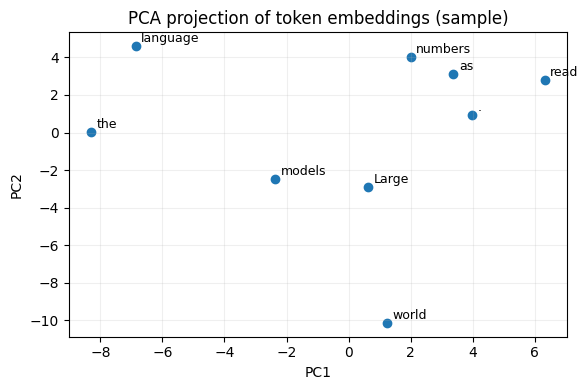

In [5]:
# Visualize (PCA) — only do this for a small set of tokens to keep plot readable
def compute_2d_projection(vectors_np):
    if _HAS_SKLEARN:
        pca = PCA(n_components=2)
        return pca.fit_transform(vectors_np)
    else:
        # simple SVD fallback
        X = vectors_np - vectors_np.mean(axis=0)
        U, S, Vt = np.linalg.svd(X, full_matrices=False)
        return U[:, :2]

# choose tokens to visualize: unique tokens from the sentence
unique_ids = list(dict.fromkeys(token_ids))
vecs = embeddings[0].detach().numpy()  # shape: (seq_len, embedding_dim)
to_plot = np.array([vecs[i] for i in range(len(unique_ids))])
proj = compute_2d_projection(to_plot)

plt.figure(figsize=(6,4))
plt.scatter(proj[:,0], proj[:,1])
for i, tid in enumerate(unique_ids):
    token_str = tokenizer.decode([tid]).strip()
    plt.annotate(token_str, (proj[i,0], proj[i,1]), textcoords='offset points', xytext=(4,3), ha='left', fontsize=9)
plt.title('PCA projection of token embeddings (sample)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


## Notes & Next Steps

- This notebook demonstrates a minimal PyTorch `nn.Embedding` layer and how token IDs map to vectors.
- `embedding_dim` is set to 128 for demo speed — for real models you will typically see 512, 768, or 1024+.
- These embeddings are **learnable** (randomly initialized here). During training the embedding weights update to capture semantics.
- Next: in Chapter 1.3 we will add **positional encoding** so the model knows token order, then move on to attention mechanisms.